In [600]:
import os
import random

import pandas as pd
import numpy as np
import torch

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score

In [420]:
# 학습 데이터와 제출파일를 불러옵니다
train = pd.read_csv('../../data/fe_data.csv') # train, test를 종합해 feature engineering을 진행한 파일 
test = pd.read_csv('../../data/test_data.csv')
submisssion = pd.read_csv('../../data/sample_submission.csv')

In [5]:
# 테스트 유저에 해당하면 test df로 분리합니다
test_users = test['userID'].unique()
pre_train_df = train[~train['userID'].isin(test_users)]
pre_test_df = train[train['userID'].isin(test_users)]

In [557]:
# 학습에 사용할 피쳐 리스트
feats = [
         # 분류
         'KnowledgeTag', 'encoded_testId',
         
         #사용자 정확도
         'user_correct_answer', 'user_total_answer','user_acc',
         'correct_shift_1', 'correct_shift_2','correct_shift_3','correct_ut_shift_1',
         
         # 전체 정보
         'test_mean','tag_mean','item_mean',
         'test_count', 'tag_count', 'item_count',  'test_sum', 'tag_sum', 'item_sum',
         
         # 시간
         'elapsed_median','normalized_elapsed','avg_elapsed_3',
         'hour', 'hour_mode', 
         'relative_time','week_num','month',
         
         #분류별 누적 통계량
         'past_assessmentItemID_count', 'average_assessmentItemID_correct','past_assessmentItemID_correct', 
         'average_testId_correct','past_testId_count','past_testId_correct',
         'average_user_testID1_correct','past_user_testID1_count','past_user_testID1_correct',
         'past_testNum_correct', 'past_testNum_count', 'average_testNum_correct',  
         'past_user_KnowledgeTag_count', 'past_user_KnowledgeTag_correct', 'average_user_KnowledgeTag_correct',
         'past_user_testId_correct', 'past_user_testId_count', 'average_user_testId_correct',
         'normalized_elapsed_user_shift_1', 'normalized_elapsed_user_shift_2', 'normalized_elapsed_user_shift_3',
        ] 

In [573]:
# train / valid을 나누는 함수
random.seed(42)
def custom_train_test_split(df, ratio=0.8, split=True):

    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)

    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [574]:
pre_train, pred_valid = custom_train_test_split(pre_train_df)

In [575]:
train_x = pre_train[feats]
train_y = pre_train['answerCode']

valid_x = pred_valid[feats]
valid_y = pred_valid['answerCode']

In [671]:
clf = XGBClassifier(
    objective='binary:logistic',
    max_depth=10,
    subsample= 1., 
    min_child_weight = 1.,
    random_state=42,
    eval_metric='auc',
    early_stopping_rounds=10,
)

In [672]:
model = clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                verbose=1)

[0]	validation_0-auc:0.84964	validation_1-auc:0.81090
[1]	validation_0-auc:0.85418	validation_1-auc:0.81560
[2]	validation_0-auc:0.85643	validation_1-auc:0.81800
[3]	validation_0-auc:0.85814	validation_1-auc:0.82231
[4]	validation_0-auc:0.85953	validation_1-auc:0.82547
[5]	validation_0-auc:0.86075	validation_1-auc:0.82675
[6]	validation_0-auc:0.86192	validation_1-auc:0.82793
[7]	validation_0-auc:0.86302	validation_1-auc:0.82902
[8]	validation_0-auc:0.86408	validation_1-auc:0.83019
[9]	validation_0-auc:0.86502	validation_1-auc:0.83112
[10]	validation_0-auc:0.86587	validation_1-auc:0.83169
[11]	validation_0-auc:0.86684	validation_1-auc:0.83191
[12]	validation_0-auc:0.86782	validation_1-auc:0.83200
[13]	validation_0-auc:0.86879	validation_1-auc:0.83263
[14]	validation_0-auc:0.86964	validation_1-auc:0.83216
[15]	validation_0-auc:0.87058	validation_1-auc:0.83330
[16]	validation_0-auc:0.87127	validation_1-auc:0.83294
[17]	validation_0-auc:0.87211	validation_1-auc:0.83348
[18]	validation_0-au

In [684]:
print(model.best_iteration, model.best_score)

78 0.8412458915139082


In [685]:
pre_test = pre_test_df[pre_test_df['userID']!=pre_test_df['userID'].shift(-2)]

test_x = pre_test[feats]

In [687]:
odd_rows = test_x.iloc[::2]
odd_real = pre_test['answerCode'].iloc[::2]
preds = model.predict_proba(odd_rows)[:,1]
print(f"예상 auc: {roc_auc_score(odd_real, preds)}")
print(f"예상 acc: {accuracy_score(odd_real, (preds>0.5).astype(int))}")

예상 auc: 0.8570550756018521
예상 acc: 0.7809139784946236


In [688]:
submission = pd.read_csv('../../data/sample_submission.csv')
submission['prediction'] = preds
submission.to_csv('submission.csv', index=False)

#### 변수가 어느 정도의 영향을 미쳤는지 볼 수 있음  
1. gain/total_gain: 노드가 특정 피쳐로 분기되었을 때 얻는 성능 상의 이득  
2. cover/total_cover: 해당 피쳐와 관련된 샘플의 상대적 개수  
3. weight: 해당 피쳐가 노드 분기에 사용된 개수  

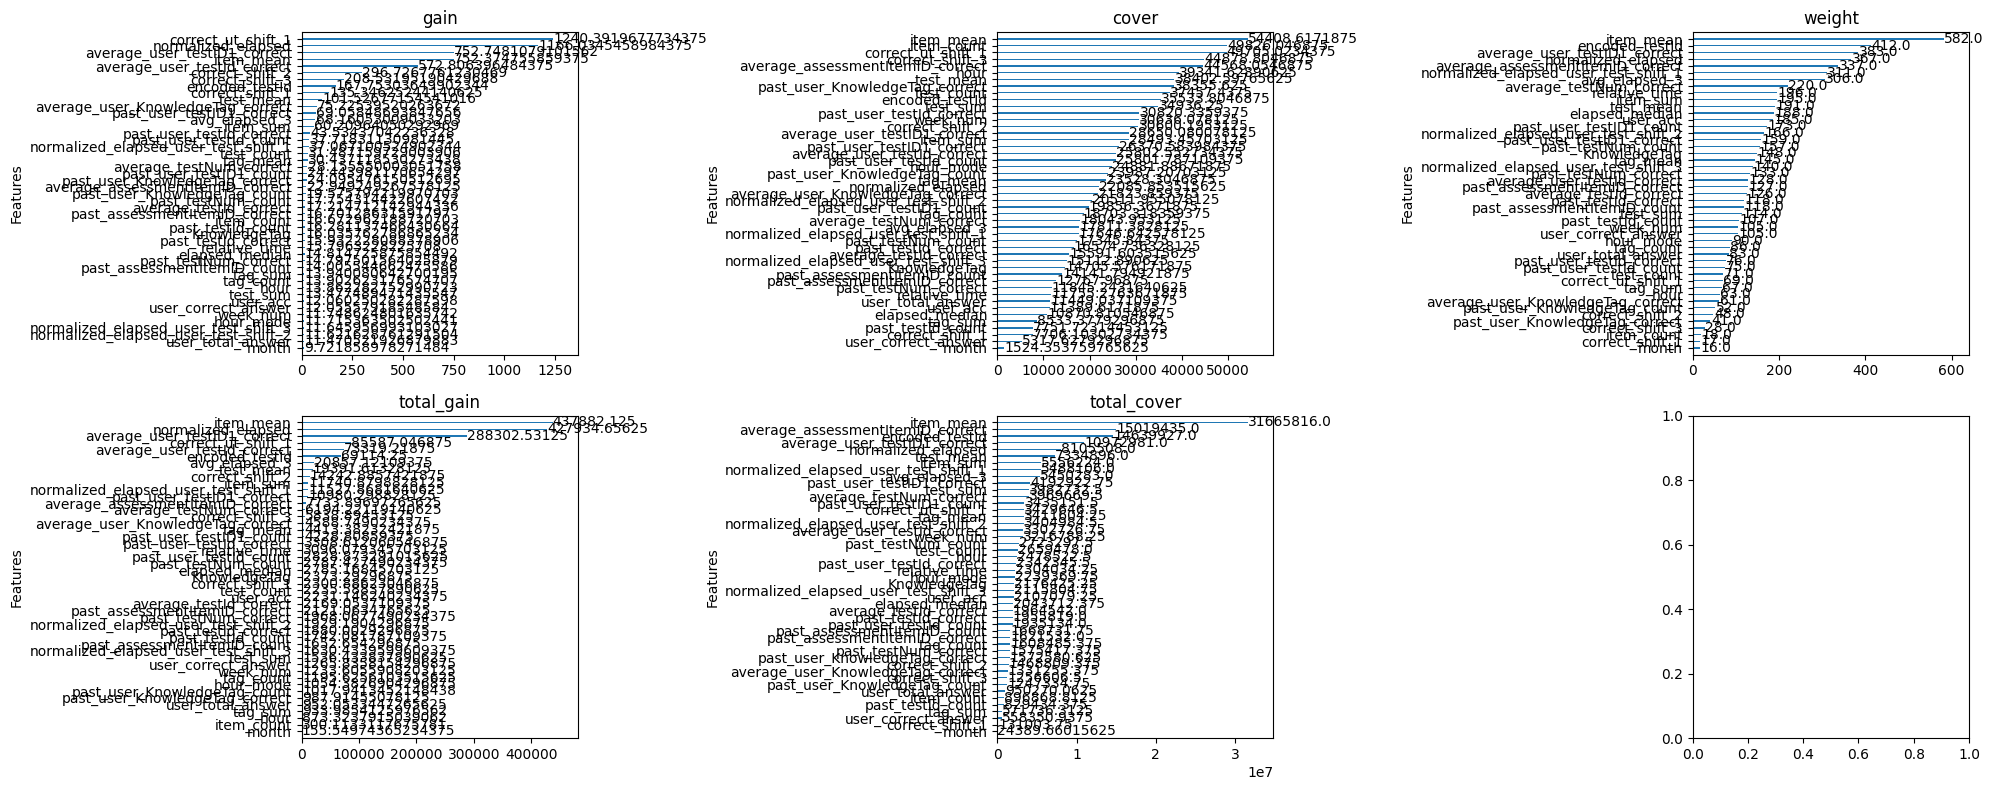

In [474]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,8))

axes = [ax for row_axes in axes for ax in row_axes]

xgb.plot_importance(model, importance_type='gain', title='gain', xlabel='', grid=False, ax=axes[0]) 
xgb.plot_importance(model, importance_type='cover', title='cover', xlabel='', grid=False, ax=axes[1])
xgb.plot_importance(model, importance_type='weight', title='weight', xlabel='', grid=False, ax=axes[2])
xgb.plot_importance(model, importance_type='total_gain', title='total_gain', xlabel='', grid=False, ax=axes[3])
xgb.plot_importance(model, importance_type='total_cover', title='total_cover', xlabel='', grid=False, ax=axes[4])

plt.tight_layout()
plt.show()

하이퍼 파라미터 자동 튜닝

In [113]:
def objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": 1,
        "learning_rate": trial.suggest_float("learning_rate",0.05, 0.1),
        "n_estimators": trial.suggest_int("n_estimators",100,700),
        "objective": "binary:logistic",
        "metric": "logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    

    model = XGBClassifier(**params_lgb)
    model.fit(
        train_x,
        train_y,
        eval_set=[(train_x, train_y), (valid_x, valid_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    lgb_pred = model.predict_proba(valid_x)
    score = log_loss(valid_y, lgb_pred)
    
    
    return score

In [114]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=100, timeout=600)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2024-01-21 13:15:32,999] A new study created in memory with name: xgb_parameter_opt
/opt/conda/envs/dkt/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/envs/dkt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:15:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/learner.cc:742: 
Parameters: { "metric", "min_child_samples", "num_leaves", "subsample_freq" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-01-21 13:17:53,255] Trial 0 finished with value: 0.5036490597478209 and parameters: {'learning_rate': 0.06872700594236814, 'n_estimators': 671, 'reg_alpha': 2.196249831492404e-05, 'reg_lambda': 0.05387926759114846, 'max_depth': 4, 'num_leaves': 41, 'colsample_bytree': 0.4348501673009197, 'subsample': 0.90632

Best Score: 0.49325975109281367
Best trial: {'learning_rate': 0.06293899908000085, 'n_estimators': 498, 'reg_alpha': 9.358215171921434e-06, 'reg_lambda': 0.04680612670532276, 'max_depth': 11, 'num_leaves': 49, 'colsample_bytree': 0.9817507766587351, 'subsample': 0.8425929763527802, 'subsample_freq': 10, 'min_child_samples': 90, 'max_bin': 379}
